# 1.5 Introdução a Redes Neurais: minha primeira Rede Neural em JAX :D

Vamos codar nossa primeira rede neural que de fato aprende com exemplos. Para isso vamos começar resolvendo o problema de regressão e classificação com bases de dados simples e fictícias para então resolver uma base de dados real.


#### Dependências

In [1]:
# Gráficos
import matplotlib.pyplot as plt

# Matemática + manipulação de vetores
import math
import numpy as np

# JAX
import jax
from jax import nn
import jax.numpy as jnp

# # "Fixar" números aleatórios a serem gerados
np.random.seed(0)

# Trabalhar com os dados
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Utilidades
import utils

# Recarregar automaticamente dependências caso elas mudem
%load_ext autoreload
%autoreload 2

### Gerando dados sintéticos

$Y = 7 * X + 15$

In [11]:
# número de dados sintéticos gerados
SYNT_TRAIN_SIZE = 200

# controla o quão espalhados são os dados
STD_DEV = 0.7

def random_error(size, mu=0, std_dev=0.5):
    return np.random.normal(mu, std_dev, size)

def add_batch_dim(tensor):
    if len(tensor.shape) == 1:
        return jnp.expand_dims(tensor, axis=1)
    else:
        return tensor

def remove_batch_dim(tensor):
    return jnp.squeeze(tensor, axis=1)
    
def generate_x(size, use_batch_dim=True):
    x = np.random.rand(size)
    if use_batch_dim:
        x = add_batch_dim(x)
    return x

def plot_line(x, y, style='-b'):
    x, y = remove_batch_dim(x), remove_batch_dim(y)
    return plt.plot([min(x), max(x)], [min(y), max(y)], style)

def generate_f(x, a=7, b=15, error_std_dev=0.5, use_batch_dim=True):
    y = a * x + b + random_error(x.shape, std_dev=error_std_dev)
    if use_batch_dim:
        y = add_batch_dim(y)
    return y
def identity(x):
    return x
def _accuracy(pred_y, real_y):
    p = np.argmax(jax.nn.softmax(pred_y), axis=1)
    return np.sum(p == real_y) / len(pred_y)
# gera valores aleatórios para x
synt_x = generate_x(SYNT_TRAIN_SIZE)

# gera a funcão: Y = 7 * X + 15
synt_y = generate_f(synt_x, error_std_dev=STD_DEV)

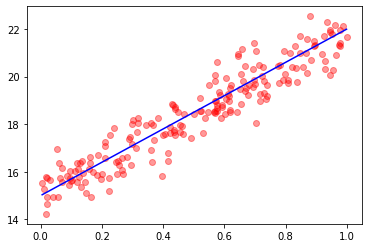

In [3]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.4)
plot_line(synt_x, synt_x * 7 + 15)
plt.show()

### Implementando Rede Neural

In [4]:
def define_params(sizes=[1, 1]):
    '''He-et-all initialization'''
    weights = []
    for i, (in_dim, out_dim) in enumerate(zip(sizes[:-1], sizes[1:])):
        weights.append({"w": np.random.randn(in_dim, out_dim) * np.sqrt(2/in_dim), 
                        "b": np.random.randn(out_dim) * np.sqrt(2/in_dim)})           
    
    return weights


def apply_fn(weights, batch_x, activations):
    output = batch_x
    for layer, act_fn in zip(weights, activations):
        output = jnp.dot(output, layer["w"]) + layer["b"]
        output = act_fn(output)
    return output

def l2_loss(weights, batch_x, real_y, activations):
    pred_y = apply_fn(weights, batch_x, activations)
    return 0.5 * np.mean((pred_y - real_y)**2)

### Implementando SGD

In [45]:
def train_step(weights, batch_x, batch_y, activations, loss_fn=l2_loss, lr=0.1):
    loss, grads = jax.value_and_grad(loss_fn)(weights, batch_x, batch_y, activations)
    weights = jax.tree_util.tree_multimap(lambda v, g: v - lr*g, weights, grads)
    return weights, loss


def evaluate(weights, activations, batch_x, batch_y, metrics=[]):
    # run feed forward network
    pred_y = apply_fn(weights, batch_x, activations)
    # loss
    loss = 0.5 * np.mean((pred_y - batch_y)**2)
    # metrics
    res_metrics = []
    for m in metrics:
        res_metrics.append(m(pred_y, batch_y))
            
    return loss, res_metrics

def plot_losses(train_losses, eval_losses, step):
    if len(eval_losses) > 0:
        plt.title('Train Loss: %.4f | Test Loss: %.4f for step %d' % (train_losses[-1], eval_losses[-1], step))
        plt.plot([i for i in range(0, step, 10)], eval_losses)
    else:
        plt.title('Train Loss: %.4f for step %d' % (train_losses[-1], step))    
        
    plt.plot([i for i in range(step)], train_losses)

### Gradients

##### L2 loss with 1 layer, no activation

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - w_i * x_i + b_i)^{2}}$$

**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial w_i} $$
$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_i$$

---

$$\frac{\partial L}{\partial b_i} = 1/2 * 1/n * 2 * \sum{(y_i - ŷ_i)} * \frac{\partial {ŷ_i}}{\partial b_i} $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$


##### L2 loss with 2 layers, relu activation in the hidden layer

**Loss**

$$L = 1/2 * 1/n * \sum{(y_i - ŷ_i)^{2}}$$
$$L = 1/2 * 1/n * \sum{(y_i - (w_j * x_j + b_j))^{2}}$$
$$x_j = relu(w_i * x_i + b_i)$$


**Gradients**

$$\frac{\partial L}{\partial w_i} = 1/n * \sum{(y_i - ŷ_i)} * x_j $$
$$\frac{\partial L}{\partial b_i} = 1/n * \sum{(y_i - ŷ_i)} * 1$$

$$\frac{\partial L}{\partial w_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j * x_i, se relu() > 0$$
$$\frac{\partial L}{\partial b_j} = 1/n * \sum{(y_i - ŷ_i)} * x_j, se relu() > 0$$

### Treinando

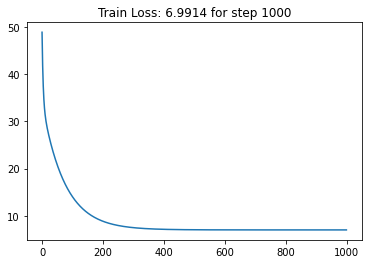

In [46]:
neural_net = define_params()
train_losses = []
eval_losses = []
for i in range(1000):
    neural_net, loss = train_step(neural_net, synt_x, synt_y, [identity])
    train_losses.append(loss)
#     if i % 10 == 0:
#         loss, metrics = evaluate(neural_net, [identity], synt_x, synt_y, metrics=[_accuracy])
#         eval_losses.append(loss)
        
plot_losses(train_losses, eval_losses, 1000)

#### Comparando com a realidade

Parâmetros aprendidos:
pesos: [[20.943336]]
bias: [-16.684555]
Função que modela os dados: 7 * X + 15


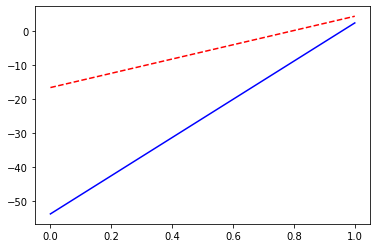

In [47]:
print('Parâmetros aprendidos:')
print('pesos:', neural_net[0]["w"])
print('bias:', neural_net[0]["b"])
print('Função que modela os dados: 7 * X + 15')
plot_line(synt_x, apply_fn(neural_net, synt_x, [identity]), '--r')
plot_line(synt_x, synt_y)
plt.show()

### Uma função um pouco mais complicada

$Y = 7 * log(x) + 1$


In [48]:
def get_random_error(size, mu=0, std_dev=0.8):
    return np.random.normal(mu, std_dev, size)

synt_x = np.random.rand(SYNT_TRAIN_SIZE)
synt_y = jnp.reshape(7 * np.log(synt_x) + 1 + get_random_error(SYNT_TRAIN_SIZE), (SYNT_TRAIN_SIZE, 1))

synt_x = jnp.reshape(synt_x, (SYNT_TRAIN_SIZE, 1))

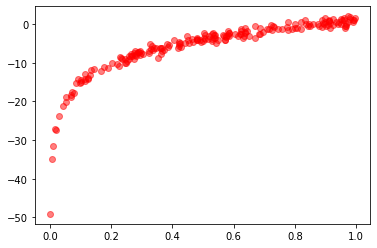

In [49]:
plt.plot(synt_x, synt_y, 'ro', alpha=0.5)

In [51]:
nn = define_params(sizes=[1, 10, 1])
activations=[jax.nn.sigmoid, identity]
train_losses = []
eval_losses = []

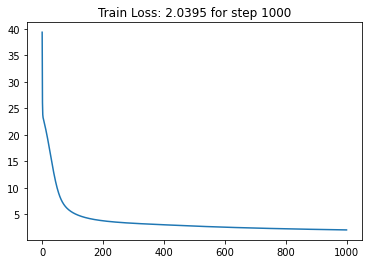

In [52]:
for i in range(1000):
    nn, loss = train_step(nn, synt_x, synt_y, activations)
    train_losses.append(loss)
#     if i % 10 == 0:
#         loss, metrics = evaluate(neural_net, [identity], synt_x, synt_y, metrics=[_accuracy])
#         eval_losses.append(loss)

plot_losses(train_losses, eval_losses, 1000)

Parâmetros aprendidos:
pesos: [DeviceArray([[  0.60046464,   4.141381  ,  -1.4826665 ,   1.1518179 ,
              -11.239479  , -10.209292  ,  -7.9020233 ,  -9.137561  ,
                4.4227676 ,  -2.2516418 ]], dtype=float32), DeviceArray([[ -0.5883246 ],
             [ -0.05585707],
             [ -1.9003814 ],
             [  0.23316236],
             [-11.544527  ],
             [-10.558471  ],
             [ -9.017403  ],
             [ -9.788867  ],
             [  6.434217  ],
             [ -2.3980281 ]], dtype=float32)]
bias: [DeviceArray([ 2.1523917 ,  2.3333447 ,  0.44241783,  1.1138563 ,
              0.17241405,  0.11032237,  0.01630486,  0.05457213,
             -2.9599383 ,  1.7303462 ], dtype=float32), DeviceArray([-2.6155922], dtype=float32)]
Função que modela os dados: 7 * X + 15


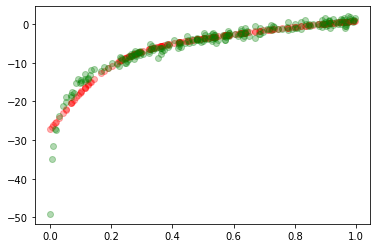

In [53]:
print('Parâmetros aprendidos:')
print('pesos:', [weight["w"] for weight in nn])
print('bias:', [weight["b"] for weight in nn])
print('Função que modela os dados: 7 * X + 15')
plt.plot(synt_x, apply_fn(nn, synt_x, activations), 'or', alpha=0.3)
plt.plot(synt_x, synt_y, 'og', alpha=0.3)
plt.show()

### E se os dados forem não lineares?

In [54]:
xor_x = jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xor_y = jnp.array([[0], [1], [1], [0]])

In [55]:
activations=[jax.nn.relu, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)
    if i % 100 == 0:
        print(apply_fn(nn, xor_x, activations))
        print(loss)

# plot_losses()

[[ 0.15335074 -0.19463566]
 [ 0.21876913 -0.47129527]
 [ 0.8510054   0.24947736]
 [ 1.3080997   0.01114985]]
1.0134251
[[0.43825203 0.49872288]
 [0.54374    0.51790726]
 [0.47162306 0.5218018 ]
 [0.53352976 0.4674046 ]]
0.11847281
[[0.38227564 0.40683848]
 [0.6668026  0.6589103 ]
 [0.57058233 0.5619002 ]
 [0.39375705 0.40050322]]
0.0775366
[[0.19500965 0.174065  ]
 [0.8701955  0.88774556]
 [0.7482096  0.72012806]
 [0.20531759 0.2425744 ]]
0.02166036
[[0.07922505 0.06484732]
 [0.95068693 0.9512994 ]
 [0.90756774 0.8836696 ]
 [0.07586001 0.10685936]]
0.003486018
[[0.03019831 0.02927586]
 [0.9831736  0.9798316 ]
 [0.96771526 0.95315516]
 [0.02534983 0.04213336]]
0.0005165634
[[0.01028924 0.0119184 ]
 [0.99421924 0.991719  ]
 [0.98930997 0.9817103 ]
 [0.00751208 0.01598665]]
7.126002e-05
[[0.00337467 0.0046469 ]
 [0.99818766 0.99676764]
 [0.9966701  0.9929278 ]
 [0.00221643 0.0061906 ]]
9.669732e-06
[[1.0619611e-03 1.7831028e-03]
 [9.9945617e-01 9.9871850e-01]
 [9.9903023e-01 9.9724877e-01

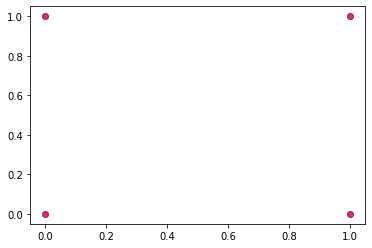

In [56]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

In [ ]:
activations=[identity, identity]
nn = define_params(sizes=[2, 10, 2])
for i in range(1000):
    nn, loss = train_step(nn, xor_x, xor_y, activations)

# plot_losses()

In [ ]:
plt.plot(xor_x, apply_fn(nn, xor_x, activations), 'bo', xor_x, xor_y, 'ro', alpha=0.3)

### Exemplo: [base dados Iris](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#iris)

Digamos que para um exemplo da base de dados queremos determinar qual a espécie dessa planta.

**Entradas**

A base de dados iris tem 4 **[atributos](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#atributos)** de uma planta que iremos usar como entrada.

**Saídas**

Neste caso a saída que nos interessa é a espécie da planta. Então digamos que a saída é um número que indica qual a espécie:

0 = Iris Setosa , 1 = Iris Versicolour, 2 = Iris Virginica

### Obtendo os dados

In [55]:
# Carregar base de dados iris
iris = fetch_openml('iris')

# np.c_ concatena as features e targets do dataset
iris_data = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                         columns=['x0', 'x1', 'x2', 'x3', 'target'])

/home/joaogui/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/datasets/_openml.py:407: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [56]:
iris_data.head()

,x0,x1,x2,x3,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [57]:
iris_data.describe()

,x0,x1,x2,x3,target
count,150.0,150.0,150.0,150.0,150
unique,35.0,23.0,43.0,22.0,3
top,5.0,3.0,1.5,0.2,Iris-setosa
freq,10.0,26.0,14.0,28.0,50


In [58]:
iris_data.drop(['target'], axis=1).diff().hist(color='k', alpha=0.5, bins=10, figsize=(4, 5))
plt.show()

ValueError: hist method requires numerical or datetime columns, nothing to plot.

In [31]:
x = iris.data
y = iris.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [32]:
def batches(x, y, batch_size=True):
    idx = np.random.permutation(len(x))
    x = x[idx]
    y = y[idx]
    
    for i in range(0, len(x)-batch_size-1, batch_size):
        batch_x = x[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        yield batch_x, batch_y

Test loss = 1.21398, accuracy 0.44737
Test loss = 1.19670, accuracy 0.52632
Test loss = 1.20644, accuracy 0.55263
Test loss = 1.20227, accuracy 0.55263
Test loss = 1.17978, accuracy 0.55263
Test loss = 1.12980, accuracy 0.55263
Test loss = 1.04272, accuracy 0.52632
Test loss = 0.90289, accuracy 0.63158
Test loss = 0.72344, accuracy 0.94737
Test loss = 0.57425, accuracy 0.94737
Test loss = 0.48888, accuracy 0.94737
Test loss = 0.44399, accuracy 0.94737
Test loss = 0.42637, accuracy 0.94737
Test loss = 0.41667, accuracy 0.94737
Test loss = 0.40954, accuracy 0.94737
Test loss = 0.40582, accuracy 0.94737
Test loss = 0.40292, accuracy 0.94737
Test loss = 0.39989, accuracy 0.94737
Test loss = 0.40108, accuracy 0.94737
Test loss = 0.40485, accuracy 0.92105
Test loss = 0.40582, accuracy 0.92105
Test loss = 0.40479, accuracy 0.92105
Test loss = 0.40645, accuracy 0.92105
Test loss = 0.40586, accuracy 0.92105
Test loss = 0.40694, accuracy 0.92105
Test loss = 0.40653, accuracy 0.92105
Test loss = 

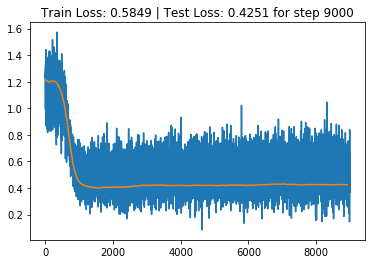

In [33]:
nn = NeuralNetwork(layers=[10, 4], input_size=4, activations=['relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy')
for i in range(1000):
    for batch_x, batch_y in batches(x, y, 16):
        t.train(batch_x, batch_y)
    if i % 10 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

### MNIIST

In [ ]:
# load mnist
mnist = fetch_mldata('MNIST original')

In [ ]:
x = mnist.data / np.max(mnist.data)
y = mnist.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
nn = NeuralNetwork(layers=[512, 256, 10], input_size=784, activations=['relu', 'relu', None])
t = Trainer(nn, verbose=False, loss_name='cross-entropy', learning_rate=0.001)
for i in range(20):
    for batch_x, batch_y in batches(x, y, 64):
        t.train(batch_x, batch_y)
    if i % 1 == 0:
        loss, metrics = t.eval(x_test, y_test, metrics=['accuracy'])
        print('Test loss = %.5f, accuracy %.5f' % (loss, metrics[0]))

t.plot_losses()

## Em busca da função perfeita


### Exemplo: [base dados Iris](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#iris)

Digamos que para um exemplo da base de dados queremos determinar qual a espécie dessa planta.

**Entradas**

A base de dados iris tem 4 **[atributos](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#atributos)** de uma planta que iremos usar como entrada.

**Saídas**

Neste caso a saída que nos interessa é a espécie da planta. Então digamos que a saída é um número que indica qual a espécie:

0 = Iris Setosa , 1 = Iris Versicolour, 2 = Iris Virginica

### Obtendo a base de dados

In [ ]:
# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Trabalhar com os dados
from sklearn.datasets import fetch_mldata

# Atributos: iris_dataset.data
# Espécie: iris_dataset.target
iris_dataset = fetch_mldata('iris')

print('Numero de exemplos na base:', len(iris_dataset.data))
print('Atributos da primeira planta:', iris_dataset.data[0])
print('Especie da primeira planta:', iris_dataset.target[0])

### Vamos codar uma função que resolve esse problema!

Uma função para resolver esse problema precisa receber 4 parâmetros (cada um dos atributos da planta) e produzir uma saída (espécie da planta).


In [ ]:
def f(x1, x2, x3, x4):
    # Não importa os atributos pra mim a resposta é sempre: Setosa!!!!
    return 0

print(f(*iris_dataset.data[0]), iris_dataset.target[0])
print(f(*iris_dataset.data[1]), iris_dataset.target[1])
print(f(*iris_dataset.data[-1]), iris_dataset.target[-1])

A função acima é válida para este problema (4 entradas, 1 saída), o problema dela é que... Ela não ta ajudando a gente no nosso problema em nada! Ela simplesmente ignora os atributos e nos diz que qualquer exemplo é da espécie Setosa.

Como podemos avaliar o quão boa é essa função? Uma métrica possível é [acurácia](https://mari-linhares.github.io/codando-deep-learning/notebooks/glossario.html#acuracia)


Por exemplo: dado um banco com a altura de determinadas pessoas (entrada), queremos estimar o "peso" dessas pessoas. Nesse caso, o "peso" das pessoas é a variável que queremos estimar. Portanto, o "peso" nesse caso representaria a nossa saída. Sempre que a nossa saída é conhecida, nós dizemos que esse tipo de problema é um problema de **Aprendizagem Supervisionada**.Há casos em que não necessariamente o nosso problema tem uma saída explícita. Nesse caso, teremos uma **Aprendizagem Não-Supervisionada**.

Além disso, quando a **saída assume qualquer valor real** (0, 1.2, 3.14, -26, +34, ...), nós dizemos que temos um **Problema de Regressão**. Por outro lado, quando a **saída é discreta** (0/1, saudável/doente, cachorro/gato/passarinho), nós temos **Problemas de Classificação**.



A grande sacada é o que acontece dentro de `f`! A ideia é que não sabemos qual o melhor `f` possível, e poderíamos tentar várias funções para se **ajustar** aos dados.

Em geral, elas são matrizes $NxD$, onde $N$ (#linhas) **representa o número de amostras** que seu banco de dados tem e $D$ (#colunas) **representa a quantidade de atributos** de cada amostra, também conhecida por *dimensionalidade*. Como exemplo, imagine que tenhamos um banco de dados com 1.000 amostras e cada amostra tem 5 atributos. Logo, nossas entradas seriam representadas por uma matriz $1000x5$, sacou? 




As entradas são representadas pelas amostras dos seus dados. Em geral, elas são matrizes $NxD$, onde $N$ (#linhas) **representa o número de amostras** que seu banco de dados tem e $D$ (#colunas) **representa a quantidade de atributos** de cada amostra, também conhecida por *dimensionalidade*. Como exemplo, imagine que tenhamos um banco de dados com 1.000 amostras e cada amostra tem 5 atributos. Logo, nossas entradas seriam representadas por uma matriz $1000x5$, sacou? 

**As saídas, por sua vez, representam o que você quer que a sua rede aprenda**. Por exemplo: dado um banco com a altura de determinadas pessoas (entrada), queremos estimar o "peso" dessas pessoas. Nesse caso, o "peso" das pessoas é a variável que queremos estimar. Portanto, o "peso" nesse caso representaria a nossa saída. Sempre que a nossa saída é conhecida, nós dizemos que esse tipo de problema é um problema de **Aprendizagem Supervisionada**. Há casos em que não necessariamente o nosso problema tem uma saída explícita. Nesse caso, teremos uma **Aprendizagem Não-Supervisionada**. Além disso, quando a **saída assume qualquer valor real** (0, 1.2, 3.14, -26, +34, ...), nós dizemos que temos um **Problema de Regressão**. Por outro lado, quando a **saída é discreta** (0/1, homem/mulher, cachorro/gato/passarinho), nós temos **Problemas de Classificação**.